# <center> Predicting Donors Choose</center>

--------

# Introduction

## Imports

https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html

In [499]:
import gc
import numpy as np
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import tqdm

In [500]:
import lightgbm as lgb

In [501]:
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

In [502]:
desk = True
demo_b = False

In [572]:
train = pd.read_csv('./Input/train.csv', low_memory=False, index_col='id')
if desk: 
    if demo_b == False:
        test = pd.read_csv('./Input/test.csv', low_memory=False, index_col='id')

res = pd.read_csv('./Input/resources.csv', low_memory=False, index_col='id')

In [573]:
train = train[:1000]
if desk:
    if demo_b == False:
        test = test[:1000]

In [574]:
if demo_b:
    demo = pd.DataFrame(train.loc['p039565']).transpose()
    del demo['project_is_approved']
    
    change_dict = {"prefix":['Mrs.','Ms.','Mr.'],
        "date":['2017-01-26','2017-02-26','2017-03-26','2017-04-26','2017-05-26','2017-06-26',
        '2017-07-26','2017-08-26','2017-09-26','2017-10-26','2017-11-26','2017-12-26',],
               "prev" : [x for x in range(0,30,5)]}

    for i in range(100):
        demo.loc['p039565'+str(i)] = demo.loc['p039565'].transpose()
        demo.set_value('p039565'+str(i),'teacher_prefix',np.random.choice(change_dict['prefix']))
        demo.set_value('p039565'+str(i),'project_submitted_datetime',np.random.choice(change_dict['date']))
        demo.set_value('p039565'+str(i),'teacher_number_of_previously_posted_projects',np.random.choice(change_dict['prev']))
        
    test = demo
    test.index.rename = 'id'

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Preprocessing

### 1.1 Resource Intergration
Here we evaluate how much each project/proposal will cost and/or how big they are

In [506]:
res['cost'] = res['quantity'] * res['price']
res_agg = res.groupby('id').agg({'description': ['nunique'], 'quantity': ['sum'], 'cost': ['mean', 'sum']})
res_agg.columns = ['unique_items', 'total_quantity', 'mean_cost', 'total_cost']
res_agg.reset_index(inplace=True)

#description was dropped because the description of the project should not have an effect on its liklihood of success

In [507]:
train = train.merge(res_agg, left_index=True, right_on='id')
if desk: 
    if demo_b : 
        for i in res_agg.columns:
            if i != 'id':
                test[i] = res_agg[res_agg['id']=='p039565'].drop('id',axis=1)[i].values[0]
    else:
        test =  test.merge(res_agg, left_index=True, right_on='id')

del res_agg
del res

### 1.2 Preprocessing of features

#### EDA

In [508]:
from sklearn.metrics import roc_auc_score

demo_2 = train[['teacher_prefix','project_is_approved']]
demo_2['naive'] = 0.867

roc_auc_score(demo_2.project_is_approved,demo_2.naive)

demo_2.drop('teacher_prefix',axis=1)

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,project_is_approved,naive
36501,1,0.867
39564,0,0.867
233822,1,0.867
185306,0,0.867
13779,1,0.867
63373,1,0.867
103284,1,0.867
181780,1,0.867
114988,1,0.867
191409,1,0.867


In [509]:
#gen_mon = train.groupby(['datetime_month','gender'])['project_is_approved'].mean().reset_index()

In [510]:
prev_mon = train.groupby('teacher_number_of_previously_posted_projects')['project_is_approved'].mean().reset_index()

In [511]:
bins = pd.cut(train['teacher_number_of_previously_posted_projects'], [0, 25, 50, 75, 100, 125, 150])
pros = train.groupby(bins)['project_is_approved'].agg('mean')

Text(0,0.5,'Mean Approvals')

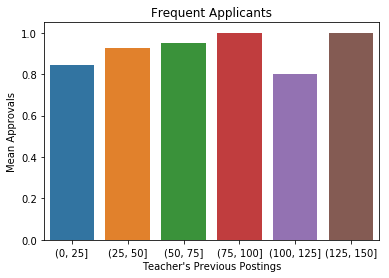

In [512]:
sns.barplot(pros.index,pros)
plt.title('Frequent Applicants')
plt.xlabel("Teacher's Previous Postings")
plt.ylabel("Mean Approvals")

In [513]:
train.project_is_approved.value_counts()

1    839
0    161
Name: project_is_approved, dtype: int64

In [514]:
"""
sns.lmplot(x="datetime_month", y="project_is_approved", hue="gender", 
           data=gen_mon[gen_mon['gender']!='Unk'], 
           order=3, 
           #ci=90
          )
plt.title('Approval rate, by month, by gender (ci:90)')
"""

'\nsns.lmplot(x="datetime_month", y="project_is_approved", hue="gender", \n           data=gen_mon[gen_mon[\'gender\']!=\'Unk\'], \n           order=3, \n           #ci=90\n          )\nplt.title(\'Approval rate, by month, by gender (ci:90)\')\n'

#### Cat Preprocessing
- Improve states
    - States are 51 because of 50 + DC

In [515]:
train.isnull().sum()[train.isnull().sum()>0]

project_essay_3    964
project_essay_4    964
dtype: int64

In [516]:
train.teacher_prefix[train.teacher_prefix.isnull()] = 'Teacher'
if desk: test.teacher_prefix[test.teacher_prefix.isnull()] = 'Teacher'

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


fill na did not work

In [517]:
def date_prep(train):
    train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'])
    train['datetime_year'] = train['project_submitted_datetime'].dt.year
    train['datetime_month'] = train['project_submitted_datetime'].dt.month

    del train['project_submitted_datetime']
    del train['project_subject_subcategories']
    return(train)

In [518]:
def gender_features(train):
    conditions = [(train.teacher_prefix == 'Mr.'), 
                  (train.teacher_prefix == 'Mrs.') | (train.teacher_prefix == 'Ms.')]
    choices = ['Male', 'Female']
    train['gender'] = np.select(conditions, choices, default='Unk')
    return(train)

In [519]:
date_prep(train)
if desk: date_prep(test)

train = gender_features(train)
if desk: test = gender_features(test)

del gender_features
del date_prep

In [520]:
gc.collect()

59

##### Encoding labels

In [521]:
# Because of memory issues, it made more sense to encode everything as a string rather than dummies
cols  = [
    'teacher_id', 
    'gender',
#    'datetime_year', already encoded
#    'datetime_month', already encoded
    'teacher_prefix', 
    'school_state', 
    'project_grade_category',
    'project_subject_categories']

for c in tqdm.tqdm_notebook(cols):
    encod = LabelEncoder()
    encod.fit(train[c].astype(str))
    train[c] = encod.transform(train[c].astype(str))

if desk: 
    for c in tqdm.tqdm_notebook(cols):
        encod = LabelEncoder()
        encod.fit(test[c].astype(str))
        test[c] = encod.transform(test[c].astype(str))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [522]:
#del cols
#del encod
del LabelEncoder
gc.collect()

0

#### Num Preprocessing

In [523]:
num_features  = ['teacher_number_of_previously_posted_projects','total_quantity', 'mean_cost', 'total_cost',]

In [524]:
SS = StandardScaler()
train[num_features] = SS.fit_transform(train[num_features])
if desk: test[num_features] = SS.fit_transform(test[num_features])

In [525]:
del num_features
del StandardScaler
del SS

In [526]:
gc.collect()

14

#### Text Preprocessing

  
#### Before May 17th, 2016:

- project_essay_1: "Introduce us to your classroom"
- project_essay_2: "Tell us more about your students"
- project_essay_3: "Describe how your students will use the materials you're requesting"
- project_essay_4: "Close by sharing why your project will make a difference"

#### May 17th, 2016 and beyond:

- project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

#### Plan
- Combine essay_1 and essay_2 before May 17th to make "student_description" and use essay_1 after May 17th directly
- Combine essay_3 and essay_4 before May 17th to make "project_description" and use essay_2 after May 17th directly

In [527]:
def essay_convert(train):
    # Making the First essay : student_description
    train['student_description']=train['project_essay_1']
    train.loc[train.project_essay_3.notnull(),'student_description']=train.loc[train.project_essay_3.notnull(),'project_essay_1']+train.loc[train.project_essay_3.notnull(),'project_essay_2']

    # Making the second essay : project_description
    train['project_description']=train['project_essay_2']
    train.loc[train.project_essay_3.notnull(),'project_description']=train.loc[train.project_essay_3.notnull(),'project_essay_3']+train.loc[train.project_essay_3.notnull(),'project_essay_4']

    # Removing original essays
    del train['project_essay_1']
    del train['project_essay_2']
    del train['project_essay_3']
    del train['project_essay_4']
    return(train)

In [528]:
essay_convert(train)
if desk: essay_convert(test)
gc.collect()

del essay_convert

### Lem & Tokenizer

In [529]:
text_features = ['project_title', 'project_resource_summary',
                'project_description', 'student_description']

In [530]:
other_stopwords = [x for x in 'abcdefghijklmnopqrstuvwxyz']
for j in ['student','students','education',]:
    other_stopwords.append(j)

In [531]:
#import gensim
from nltk.corpus import stopwords
def scrub(text):
    text = text.strip().lower()
    text = re.sub('\W+',' ', text)    
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\:', ' ', text)
    text = re.sub(r'\+', ' ', text)
    text = re.sub(r'\=', ' ', text)
    text = re.sub(r'(\")', ' ', text)
    text = re.sub(r'(\r)', ' ', text)
    text = re.sub(r'(\n)', ' ', text)
    text = re.sub(r'(\\)', ' ', text)
    text = re.sub('n t ','n\'t ', text)
    text = re.sub(' re ',' are ', text)
    text = re.sub(r'(\r\n)', ' ', text)
    text = re.sub(r'\"\"\"\"', ' ', text)
    text = re.sub(' i m ',' i\'m ', text)
    text = ' '.join([word for word in text.split() if word not in (other_stopwords + stopwords.words("english"))])
    return(text)

In [532]:
gc.collect()

0

In [533]:
for j in tqdm.tqdm_notebook(text_features):
    n_col = 'processed_'+j
    train[n_col] = train[j].apply(lambda x: scrub(x))
    if desk: test[n_col] = test[j].apply(lambda x: scrub(x))

gc.collect()
for i in text_features:
    del train[i]
    if desk: del test[i]

del stopwords
del other_stopwords
del text_features

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

Exception in thread Thread-20:
Traceback (most recent call last):
  File "/Users/Nahel/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/Nahel/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Nahel/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



## Modeling

### Tfidf & X,y Assignment

In [534]:
gc.collect()

56

In [535]:
cols = [
    'processed_project_title',
    'processed_project_resource_summary', 
    'processed_project_description',
    'processed_student_description']

In [536]:
for i in cols:
    print("Average length in {} is {} words".format(i,str(round(train[i].str.len().mean()))))

Average length in processed_project_title is 25 words
Average length in processed_project_resource_summary is 79 words
Average length in processed_project_description is 525 words
Average length in processed_student_description is 413 words


In [537]:
n_features = [
    200, 
    400, 
    2500,
    2500]

In [538]:
gc.collect()

122

In [539]:
for c_i, c in tqdm.tqdm_notebook(enumerate(cols)):
    tfidf = TfidfVectorizer(
        max_features=n_features[c_i])

    tfidf.fit(train[c])

#    tfidf_train2 = tfidf.transform(train[c])

    tfidf_train = np.array(tfidf.transform(train[c].values).toarray(), dtype=np.float16)
    for i in range(n_features[c_i]):
        train[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
    if desk:
        tfidf_test = np.array(tfidf.transform(test[c].values).toarray(), dtype=np.float16)
        for i in range(n_features[c_i]):
            test[c + '_tfidf_' + str(i)] = tfidf_test[:, i]

for i in cols:
    del train[i]
    if desk: del test[i]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [540]:
train = train.reset_index()
del train['index']

In [541]:
drop_cols = ['project_is_approved','unique_items','id','teacher_id']

X = train.drop(drop_cols, axis=1)
y = train['project_is_approved']

#del train

In [544]:
#if running demo, uncomment this and change test['id'].vaues -> test['index'].values
#test = test.reset_index()

In [545]:
X_test = test.drop(drop_cols, axis=1, errors='ignore')
id_test = test['id'].values
feature_names = list(X.columns)

### Grid search over Gradient Boosting

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [ ]:
#gb_tuned_parameters = {
#                        "n_estimators": [x for x in range(100, 400, 2)],
#                        'min_samples_split' : [3],
#                        'max_depth': [20]}

In [ ]:
#rs = RandomizedSearchCV(GradientBoostingClassifier(),
#                        gb_tuned_parameters,
#                        n_iter=30, 
#                        scoring='roc_auc', 
#                        cv=StratifiedKFold(), 
#                        verbose=10,)

In [ ]:
#rs.fit(X, y)

### Grid Search over LGBM

In [ ]:
model = lgb.LGBMClassifier( 
    boosting_type="gbdt",
    is_unbalance=True, 
    random_state=10,
    bagging_freq=5, 
    learning_rate=0.025,
    min_child_samples=3,
    verbose=1)

In [ ]:
params_opt = {'n_estimators':  range(50, 100, 5),
             'max_depth': range(15, 30),
             'feature_fraction': [x / 1000.0 for x in range(825,900,25)],
             'bagging_fraction': [x / 1000.0 for x in range(825,900,25)],
             'num_leaves':range(20,50,5)}

In [ ]:
rs = RandomizedSearchCV(
    model, 
    params_opt, 
    n_iter=10,
    scoring='roc_auc',
    verbose=1,
    cv=3)
rs.fit(X,y)
rs.best_score_

In [ ]:
train.head()

### Best LGBM

In [576]:
# Build the model
cnt = 0
n_splits = 5
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=42)

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 20,
        'num_leaves': 31,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'verbose': 0,
        'min_gain_to_split': 3,}  

    lgb_train = lgb.Dataset(
        X.loc[train_index], 
        y.loc[train_index], 
        feature_name=feature_names)

    lgb_valid = lgb.Dataset(
        X.loc[valid_index], 
        y.loc[valid_index])

    model = lgb.train(
        params, lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100,
        verbose_eval=10,)

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break
    
    cnt = cnt+1

Fold 1/5
Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.849842	valid_1's auc: 0.581566
[20]	training's auc: 0.870429	valid_1's auc: 0.6117
[30]	training's auc: 0.891184	valid_1's auc: 0.598214
[40]	training's auc: 0.909963	valid_1's auc: 0.58324
[50]	training's auc: 0.912539	valid_1's auc: 0.59375
[60]	training's auc: 0.926975	valid_1's auc: 0.600539
[70]	training's auc: 0.939209	valid_1's auc: 0.613653
[80]	training's auc: 0.945251	valid_1's auc: 0.608445
[90]	training's auc: 0.953835	valid_1's auc: 0.600446
[100]	training's auc: 0.966959	valid_1's auc: 0.593564
[110]	training's auc: 0.970933	valid_1's auc: 0.594866
[120]	training's auc: 0.975635	valid_1's auc: 0.595982
[130]	training's auc: 0.979078	valid_1's auc: 0.591704
[140]	training's auc: 0.982636	valid_1's auc: 0.588914
[150]	training's auc: 0.983641	valid_1's auc: 0.590402
[160]	training's auc: 0.986657	valid_1's auc: 0.579427
Early stopping, best iteration is:
[65]	training's auc: 0.935

In [547]:
del X_test['index']
p = model.predict(X_test, num_iteration=model.best_iteration)

In [580]:
idf = tfidf.idf_
idf_map = dict(zip(tfidf.get_feature_names(), idf))

In [587]:
tfidf.get_feature_names()[75]

'accelerated'

In [588]:
tfidf.idf_[75]

6.52246041819533

In [581]:
#idf_map

{'00': 6.810142490647111,
 '000': 6.116995310087166,
 '10': 5.13616605707544,
 '100': 3.9769291465908947,
 '10th': 6.116995310087166,
 '11': 5.962844630259907,
 '110': 6.52246041819533,
 '12': 4.864232341591798,
 '125': 6.52246041819533,
 '12th': 6.29931686688112,
 '13': 5.829313237635384,
 '14': 5.829313237635384,
 '15': 6.116995310087166,
 '150': 6.29931686688112,
 '16': 6.29931686688112,
 '17': 6.116995310087166,
 '18': 5.4238481295272205,
 '19': 5.962844630259907,
 '1st': 5.13616605707544,
 '20': 4.91302250576123,
 '200': 6.52246041819533,
 '2016': 5.6061696863211745,
 '2017': 6.29931686688112,
 '21': 5.962844630259907,
 '21st': 4.650658241293739,
 '22': 5.711530201979001,
 '23': 5.6061696863211745,
 '24': 5.13616605707544,
 '25': 5.200704578213011,
 '250': 6.52246041819533,
 '26': 6.52246041819533,
 '28': 6.116995310087166,
 '2nd': 4.864232341591798,
 '30': 5.075541435259004,
 '300': 6.52246041819533,
 '35': 6.52246041819533,
 '3rd': 4.96431580014878,
 '40': 5.269697449699962,
 '4

In [548]:
submit = pd.DataFrame({'id':id_test,'pred':p})

In [567]:
#submit.sort_values('pred',axis=0,)

,id,pred
0,p039565,0.711640
28,p03956527,0.711640
37,p03956536,0.711640
26,p03956525,0.711640
44,p03956543,0.711640
49,p03956548,0.711640
52,p03956551,0.711640
22,p03956521,0.711640
53,p03956552,0.711640
55,p03956554,0.711640
